### Neural Network implementation from scratch using python

Hi Folks lets learn implementing neural networks from scratch using pure python and not using any ML modules.
I am assuming that we have a bit knowledge in python and ML and implementing the Neural Networks based on it.

This Notebook consists of following modules:
- Neural Netwrok Layers
- weight initialization
- Model Development
- Gradient Descent and Weight updation
- Training the algorithm for multiple epoches

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['figure.figsize']=(20,20)
%matplotlib inline

### Activation Functions
Activation functions are generally used for adding non-linearity to the function and there are so many non-linear functions and a few of useful non-linear functions are
- sigmoid
- tanh
- ReLU
- leaky ReLU
- softmax

In [2]:
class activationFunctions:
    def __init__(self, input:np.ndarray, activation='linear'):
        self.activation = activation
        self.input = input
        self.result = self.selectActivation(activation)
    
    def selectActivation(self):
        switcher = {
            'linear' : input,
            'sigmoid' : self.sigmoid(input),
            'tanh' : self.tanH(input),
            'relu' : self.relu(input),
            'leakyRelu' : self.leakyRelu(input),
            'softmax': self.softmax(input)
        }
        return switcher.get(self.activation, 'notDefined')

    @staticmethod
    def sigmoid(self) -> np.ndarray:
        return (1.0)/(1+np.exp(-self.input))
    
    @staticmethod
    def tanH(self) -> np.ndarray:
        return (np.exp(self.input)-np.exp(-self.input))/(np.exp(self.input)+np.exp(-self.input))
    
    @staticmethod
    def relu(self) -> np.ndarray:
        return np.max(0,self.input)

    @staticmethod
    def leakyRelu(self) -> np.ndarray:
        return np.where(self.input>0, self.input, self.input*0.01)
    
    @staticmethod
    def softmax(self) -> np.ndarray:
        return np.exp(self.input)/(np.sum(np.exp(self.input), axis=0))
    

### Data Normalization and standardization
- Normalization (x-min)/(max-min)
- Standardization (x-mue)/std

In [3]:
class dataNormalization:
    def __init__(self, input:np.ndarray, standard:bool=False)->np.ndarray:
        self.input = input
        if ~standard:
            self.result =  self.normalize()
        else:
            self.result =  self.standardize()
    
    def normalize(self)-> np.ndarray:
        self.max = np.max(self.input)
        self.min = np.min(self.input)
        return (self.input-self.min)/(self.max - self.min)

    def standardise(self) -> np.ndarray:
        self.mean = np.mean(self.input)
        self.std = np.std(self.input)
        return (self.input - self.mean)/(self.std)

### One hot encoding the outputs
In case of classification output is categoriical which needs a special format one hot encoding is best suitable format for that. One hot encoding results the binary code with only one bit highlighted corresponding to class number.

In [4]:
def one_hot_encode(input:np.ndarray, num_of_labels:int) -> np.ndarray:
    return np.eye(num_of_labels)[input]

### Derivative Functions
This section deals with the derivatives of some of the activation function which eases our implemntation 
Follwing results are derivative results with respect to input
- Derivative of sigmoid = sigmoid * (1-sigmoid)
- Derivative of tanh = 1- tanh2
- Derivative of relu = 1 when input>0 else 0
- Derivative of leaky relu = 1 when input>0 else 0.01

In [5]:
def derivative(activation:str, input:np.ndarray) -> np.ndarray:
    act = activationFunctions(input, activation=activation)
    
    if activation=="sigmoid":
        return  act.result * (1- act.result)
    elif activation=="tanh":
        return 1 - np.square(act.result)
    elif activation == "relu":
        return (input>0)*1
    elif activation=="leakyRelu":
        return np.where(input>0, 1, 0.01)
    elif activation=="linear":
        return input
    else:
        return "no such activation"
    

### Neural Netwrok Implemntation
So far we developed all the required functions now we use all those along with some more mathematical implementations of the network

Usually any neural network involves three steps
- Feed Forward Propogation
- Cost estimation
- Back Prpogation

After these we will estimate the model performance using accuracy metrics according the problem definition

In [6]:
config = dict()
config['hiddenLayers'] = {
    1:{'units':128, 'activation':'relu'},
    2:{'units':64, 'activation':'relu'}
    }

In [7]:
class createNN:
    def __init__(self, input:np.ndarray, output:np.ndarray, config:dict, classification=False):
        self.config = config
        self.classification = classification
        self.input = input
        self.norm = dataNormalization(self.input)
        self.X = self.noram.result
        assert np.all((self.X>=0) & (self.X<=1)) # test whether normalization worked on not
        self.y = output
        if self.classification:
            self.y = one_hot_encode(output, np.unique(output))
        self.inputVectorDims = self.X.shape[0]
        self.noOfSamples = self.X.shape[1]
        self.layers = {}
        self.parameters = {}
        self.L = len(config['hiddenLayers'])+1
        self.architecture = self.config['hiddenLayers']
        self.architecture[0] = {'units':self.inputVectorDims,'activation':'linear'}
        self.architecture[len(self.architecture)] = {'units':len(np.unique(output)), 'activation': 'softmax' if classification else 'linear'}
        
    def initializeParamters(self, method=None):
        # follow this link for more information on Weight Initialization
        # https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
        for i in range(1, self.L+1):
            print(f"Initializing the parameters for the layer {i}...")
            self.parameters[f'w{i}'] = np.random.randn(self.config[i]['units'], self.config[i-1]['units'])
            self.parameters[f'b{i}'] = np.zeros(self.architecture[i]['units'], 1)
    
    def forwardPropogation(self):
        params = self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L+1):
            self.layers[f'z{l}'] = np.dot(params[f'w{l}'], self.layers[f'a{l-1}']) + params[f'b{l}']
            self.layers[f'a{l}'] = activationFunctions(self.layers[f'z{l}'], self.architecture[l]['activation']).result
        
        self.output = self.layers[f'a{self.L}']
        self.cost = self.estimateError()

    def estimateError(self):
        if self.classification:
            return -np.sum(self.output * np.log(self.output + 0.000000001)) 
            # added 0.00000001 to avoid divisionn by zeros
        else:
            return np.square(self.predictions-self.output)

    def backPropogation(self):
        # derivative of cross entropy loss wrt softmax is (preidtcions - labels)
        # please refer https://deepnotes.io/softmax-crossentropy#:~:text=Derivative%20of%20Softmax,-Due%20to%20the&text=In%20our%20case%20%5C(g,%5C(e%5E%7Ba_j%7D%5C).
        derivatives = {}
        if self.classification:
            dZ = self.output - self.y
        else:
            da = -(2/self.noOfSamples)*(np.sum(self.y-self.output))
            daz = derivative(self.architecture[self.L]['activation'], self.layers[f'a{self.L}'])
            dZ = da*daz
        dW = np.dot(dZ, self.layers[f'a{self.L-2}'].T)/self.noOfSamples
        db = np.sum(dZ, axis=1, keepdims=True)/self.noOfSamples
        dAPrev = np.dot(self.parameters[f'w{self.L-1}'].T, dZ)
        derivatives[f'dW{self.L-1}'] = dW
        derivatives[f'db{self.L-1}'] = db

        for l in range(self.L-1, 0, -1):
            dZ = dAPrev * derivative(self.architecture[l+1]['activation'], self.layers[f'z{l}'])
            dW = (1./self.noOfSamples) * (np.dot(dZ, self.layers[f'a{l-1}'].T))
            db = (1./self.noOfSamples) * (np.sum(dZ, axis=1, keepdims=True))
            if l>1:
                dAPrev = np.dot(self.parameters[f'w{l}'].T, dZ)
            derivatives[f'dW{l}'] = dW
            derivatives[f'db{l}'] = db

        self.derivatives = derivative

    def fit(self, lr=0.01, epochs=1000):
        self.costs = []
        self.initializeParamters()
        self.accuracies = {'train': [], 'val':[]}
        for epoch in tqdm(range(epochs), color='BLUE'):
            cost, cache = self.forwardPropogation()
            self.costs.append(self.cost)
            self.backPropogation()
            for layer in range(1, self.L+1):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * self.derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * self.derivatives["db" + str(layer)]  

            train_accuracy = self.accuracy(self.X, self.y)
            val_accuracy = self.accuracy(self.X_val, self.y_val)

            if epoch %10 ==0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")

            self.accuracies["train"].append(train_accuracy)
            self.accuracies["val"].append(val_accuracy)

    def accuracy(self, X, y):
        P = self.predict(X)
        return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100
    
    def predict(self, X):
        params = self.parameters
        values = [X]
        for l in range(1, self.L):
            z = np.dot(params[f"w{l}"], values[l-1]) + params[f'b{l}']
            a = eval(self.architecture[l]['activation'])(z)
            values.append(a)
        if X.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        
        return ans



In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name="mnist_784")

print(mnist.keys())

data = mnist.data
labels = mnist.target

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


67215
(784,)
3
(784,)
Image label: 3


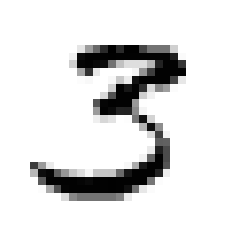

In [10]:
n = np.random.choice(np.arange(data.shape[0]+1))

print(n)

test_img = data.iloc[n].values
print(test_img.shape)
test_label = mnist.target.iloc[n]
print(test_label)

print(test_img.shape)

side_length = int(np.sqrt(test_img.shape))
reshaped_test_img = test_img.reshape(side_length, side_length)

print("Image label: " + str(test_label))

plt.imshow(reshaped_test_img, cmap="Greys")
plt.axis('off')
plt.show()

In [24]:
train_test_split_no = 60000
X_train = data.values[:train_test_split_no].T
y_train = labels[:train_test_split_no].values.astype(int)
X_test = data.values[train_test_split_no:].T
y_test = labels[train_test_split_no:].values.astype(int)

print(X_train.shape, X_test.shape)

PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [128, 32]]
nn_relu = NN(*PARAMS)
epochs_relu = 200
lr_relu = 0.003
nn_relu.fit(X_train, y_train, lr=lr_relu, epochs=epochs_relu)
nn_relu.plot_cost(lr_relu)

(784, 60000) (784, 10000)


NameError: name 'NN' is not defined